In [8]:
from importlib import reload
# Tips to me:
# Use Python 3.11.6
# That's in the location /opt/homebrew/bin/python3

# Libraries
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import dataset
from IPython.display import Audio
from Nets import complicatedNet
from torch.nn import functional as F
import models
from pathlib import Path

In [2]:
reload(dataset)
allset = dataset.AudioDatasetAt("datasets/clips/test")


In [3]:
# Getting a random data
wf = allset.get_random()
inp = wf.unsqueeze(0)
print(inp.shape)
Audio(wf, rate=32000)

Getting 250th from the 1367 datasets.
torch.Size([1, 1, 96000])


In [16]:
# Run following two cells in order to check if dataloaders work properly

reload(dataset)
# Check Loaders
from torch.utils.data import DataLoader
loader = DataLoader(allset, 64, True, collate_fn=dataset.my_collater)

In [17]:
# return
i = 0
for d in loader:
    i += 1
    if i > 10:
        break
    print(d.shape)

torch.Size([152, 1, 96000])
torch.Size([150, 1, 96000])
torch.Size([158, 1, 96000])
torch.Size([150, 1, 96000])
torch.Size([195, 1, 96000])
torch.Size([163, 1, 96000])
torch.Size([155, 1, 96000])
torch.Size([160, 1, 96000])
torch.Size([50, 1, 96000])


In [39]:
# Instantiating Encoder, Quantizer and Decoder
reload(complicatedNet)
encoder = complicatedNet.Encoder(4)
quantizer = torch.nn.Identity()
decoder = complicatedNet.Decoder(4)
model = models.allNet(encoder=encoder, quantizer=quantizer, decoder=decoder)
wf = allset.get_random()
inp = wf.unsqueeze(0)
x = inp
print(x.shape)
x = encoder(x)
x = quantizer(x)
x = decoder(x)
out = x
print(x.shape)

/opt/homebrew/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Getting 425th from the 536 datasets.
torch.Size([1, 1, 201600])
torch.Size([1, 1, 201600])


In [22]:
# Instantiating another model
reload(complicatedNet)
encoder = complicatedNet.Encoder(4)
quantizer = torch.nn.Identity()
decoder = complicatedNet.Decoder(4)
my_model = models.allNet(
    encoder=encoder, quantizer=quantizer, decoder=decoder
)
device = 'mps'
my_model.to(device)

x = wf.unsqueeze(0).to(device)
output = my_model(
    x
    ).cpu().detach().numpy()

Audio(output[0], rate=32000)



In [24]:
idx = 0
size = 13
remaining = lambda : size - idx

In [31]:
idx += 2
remaining()

3

In [59]:
spectrogramer1 = torchaudio.transforms.MelSpectrogram(32000)
spectrogramer2 = torchaudio.transforms.MelSpectrogram(32000)

/opt/homebrew/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [82]:
image1 = spectrogramer1(inp).cpu().detach()
image2 = spectrogramer1(out).cpu().detach()
image1 = F.interpolate(image1, scale_factor=.1, mode='bilinear').squeeze()
image2 = F.interpolate(image2, scale_factor=.1, mode='bilinear').squeeze()
# image1 = F.interpolate(image1, mode='linear', scale_factor=10).squeeze()
image1.shape, image2.shape

(torch.Size([12, 100]), torch.Size([12, 100]))

<Figure size 2000x700 with 0 Axes>

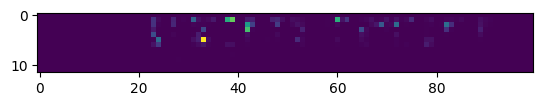

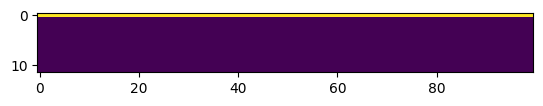

In [83]:
plt.figure(figsize=(20,7))
plt.figure(211)
plt.imshow(image1)
plt.figure(212)
plt.imshow(image2)

In [4]:
import matplotlib.pyplot as plt
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

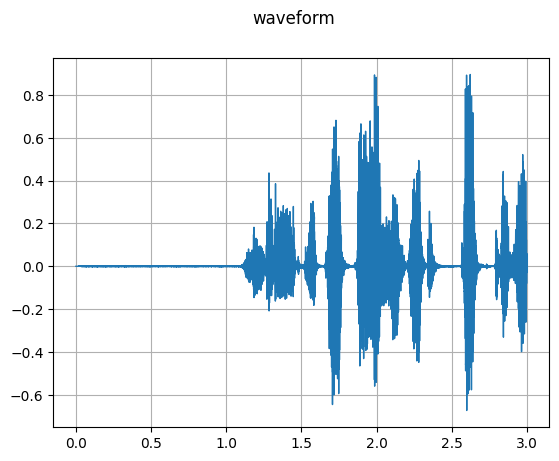

In [5]:
from IPython.display import Audio
plot_waveform(wf, 32000)

In [11]:
wavef, samr = torchaudio.load("datasets/clipses/common_voice_en_38487414.mp3")
info = torchaudio.info("datasets/clipses/common_voice_en_38487414.mp3")

In [18]:
print(info)

AudioMetaData(sample_rate=32000, num_frames=182016, num_channels=1, bits_per_sample=0, encoding=MP3)


In [28]:
from pathlib import Path
import pandas as pd

counting_tool = lambda  x, y : (x-1)//y + 1

def isAudioFile(filename):
    try:
        file = Path(filename)
        torchaudio.info(file)
        return True
    except:
        return False

def file_counts(folder, numSamples, limit=0):
    audios = pd.DataFrame(columns=["name", "channel", "start"])
    l = 0
    for file in Path(folder).rglob("*"):
        l += 1
        if limit and l > limit:
            break
        if not isAudioFile(file):
            continue

        audio = torchaudio.info(file)
        frame_count = audio.num_frames
        channel_count = audio.num_channels

        for i in range(counting_tool(frame_count, numSamples)):
            for channel in range(channel_count):
                start = i*numSamples
                audios.loc[len(audios.index)] = (file, channel, start)

    return audios


# Selects each file's expected portion
from torch.nn import functional as F
def selector(file, numSamples):
    wf, rate = torchaudio.load(file.name, frame_offset=file.start, num_frames=numSamples)
    padding = numSamples - wf.shape[-1]
    return F.pad(wf[file.channel].unsqueeze(0), [0, padding])

def sampler(df, numSamples):
    return torch.stack(
        [selector(file, numSamples) for file in df.itertuples()]
    )
    # data = torch.stack(F.pad(wf[each_data.Channel].unsqeeze(0) for wf, rate in  torchaudio.load(each_data.Filename, frame_offset=each_data.Start, num_frames=(numSamples))), [0, numSamples-each_data.End - each_data.Start])


files_df = file_counts("datasets/clips/test", 32000, limit=0)#.iloc[10:20]
# print("Files data", files_df)
print(len(files_df.index))

# print("Experimenting with itertuples")
# print("name", "channel", "start")
# for file in files_df.itertuples():
#     print(file.name, file.channel, file.start)

# samples = sampler(files_df, 32000)

# print(samples.shape)

# torch.cat([sample for sample in samples], dim=0).shape
# Audio(torch.cat([sample for sample in samples], dim=1), rate=32000)
# Audio(torchaudio.load("datasets/clipses/common_voice_en_38692488.mp3")[0], rate=32000)


# print("hello")
# Audio(torchaudio.load("datasets/clips/test/common_voice_en_39405726_1.mp3")[0], rate=32000)
# for file in Path("datasets/clips").glob("*"):
#     if Path(file).is_file:
#         try:
#             torchaudio.load(file)
#         except:
            


4101


In [1]:
import dataset_creator

In [29]:
counting_tool(182000, 32000)

6

In [50]:
reload(dataset_creator)
dataset = dataset_creator.AudioDatasetAt("datasets/clipses", limit=1000)

In [57]:
dataset[4].shape

torch.Size([1, 96000])

In [49]:
# len(dataset)
dataset.files_df.iloc[0]#["channel"]

0

In [10]:
i = len([None for file in Path("datasets/clipses").rglob("*") if file.is_file])

In [37]:
import pandas as pd
def isAudioFile(filename):
    try:
        file = Path(filename)
        fileinfo = torchaudio.info(ile)
        return (fileinfo.num_channels, fileinfo.num_frames)
    except:
        return False
counting_tool = lambda  x, y : (x-1)//y + 1

def something(folder, numSamples):
    audios = pd.DataFrame(columns=["name", "channel", "start"])
    i = 0
    for file in Path(folder).rglob("*"):
        if fileinfo := isAudioFile(file):
            ch, size = fileinfo
            counts = counting_tool(size, numSamples)
            how_many = ch*counts
            i += ch * counts
            new_row = pd.DataFrame({
                "name":[file]*how_many, 
                "channel":[i for i in range(ch)] * counts, 
                "start":[i*numSamples for i in range(counts)] * ch
                })
            audios=pd.concat([audios,new_row])
    return i, audios

audios = something("datasets/clips/test", 32000)
print(i)
audios.reset_index(drop=True)
audios.iloc[:5]



4101


,name,channel,start


In [15]:
[i*25 for i in range(4)] * 2

[0, 25, 50, 75, 0, 25, 50, 75]

In [19]:
[i for i in range(2)]*2

[0, 1, 0, 1]

In [2]:
import torch
value = torch.Tensor([0])

In [12]:
value.requires_grad_()
value

tensor([0.], requires_grad=True)